# Cortical network model simulations for hFUS paper

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# External imports
import os
import time
from datetime import timedelta
import matplotlib.pyplot as plt

# Internal imports
from network import NeuralNetwork
from logger import logger
from utils import *

# Record notebook start time
t0 = time.perf_counter()

# Set up figures directory and initialize figures dictionary
figs_dir = 'figures/'
figs = {}

## Input parameters

In [3]:
# Drive parameters
noise_amp = 5e-3  # noise amplitude (mA/cm2)

# Stimulus parameters
start = 50 # start time (ms)
dur = 150  # duration (ms)
Pmax = 3e6  # maximum pressure amplitude (Pa)
Imax = pressure_to_intensity(Pmax) / 1e4  # corresponding intensity (W/cm2)
Isppa_range = sqrtspace(0, Imax, 15)  # range of intensities to sweep
Isppa_range_dense = sqrtspace(0, Imax, 30)  # dense range of intensities to sweep

# Simulation parameters
tstop = 350  # default simulation duration (ms)
nreps = 50  # number of repetitions per simulation (for sweep trends)

# Logging
paramsstr = {
    'noise': [
        f'amplitude = {noise_amp:.3f} mA/cm2'],
    'stimulus': [
        f'start = {start} ms',
        f'duration = {dur} ms',
        f'range of intensities = {Isppa_range[0]:.2f} - {Isppa_range[-1]:.2f} W/cm2'],
    'simulation': [
        f'duration = {tstop} ms',
        f'number of repetitions (for sweeps) = {nreps}']
}
paramsstr = {k: '\n'.join([f'       - {x}' for x in v]) for k, v in paramsstr.items()}
paramsstr = '\n'.join([f'   - {k}:\n{v}' for k, v in paramsstr.items()]) 
logger.info('Input parameters:\n' + paramsstr)

 13/02/2024 10:40:39: Input parameters:
   - noise:
       - amplitude = 0.005 mA/cm2
   - stimulus:
       - start = 50 ms
       - duration = 150 ms
       - range of intensities = 0.00 - 278.22 W/cm2
   - simulation:
       - duration = 350 ms
       - number of repetitions (for sweeps) = 50


## Network model

In [4]:
# Initialize 3-nodes model temperature-dependent components
nnodes = 3
model = NeuralNetwork(
    nnodes,
    Q10_rates=3,
    Q10_gNa=1.40,
    Q10_gKd=4.75,
    gKT=NeuralNetwork.gKT_default,  # S/cm2
    a=1e-4, 
    b=0.5,
    synweight=90e-6, # synaptic weight (S/cm2)
)

# Set stimulus start and duration
model.start = start
model.dur = dur

# Set simulation duration
model.tstop = tstop

 13/02/2024 10:40:39: NeuralNetwork(3): created 3 nodes
 13/02/2024 10:40:39: NeuralNetwork(3): connecting 100.0% (6/6) of candidate node pairs
 13/02/2024 10:40:39: NeuralNetwork(3): setting Q10_rates = 3 on all nodes
 13/02/2024 10:40:39: NeuralNetwork(3): setting Q10_gNa = 1.4 on all nodes
 13/02/2024 10:40:39: NeuralNetwork(3): setting Q10_gKd = 4.75 on all nodes
 13/02/2024 10:40:39: NeuralNetwork(3): setting gKT = 4.898648648648648e-06 on all nodes
 13/02/2024 10:40:39: NeuralNetwork(3): setting a = 0.0001 on all nodes
 13/02/2024 10:40:39: NeuralNetwork(3): setting b = 0.5 on all nodes
 13/02/2024 10:40:39: NeuralNetwork(3): initialized


## Simulations

### Parametric exploration to find spiking threshold without stochastic noise

 13/02/2024 10:40:40: Spiking threshold: 33.08 W/cm2 <-> 0.58 uA/cm2


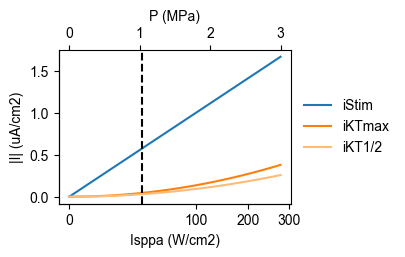

In [5]:
# Find spiking threshold and corresponding current amplitude
model.verbose = False
for Isppa in Isppa_range_dense:
    model.set_stim(Isppa)
    data = model.simulate()
    nspikes = model.compute_metric(data, 'nspikes')
    if nspikes.max() > 0:
        spike = True
        break
model.verbose = True
Ithr = Isppa
iStimthr = data['iStim'].abs().max()
logger.info(f'Spiking threshold: {Ithr:.2f} W/cm2 <-> {iStimthr * 1e3:.2f} uA/cm2')

# Plot EI imbalance over intensity range, and mark spiking threshold
figs['EI imbalance'] = model.plot_EI_imbalance(Imax, xscale='sqrt')
figs['EI imbalance'].axes[0].axvline(Isppa, color='k', linestyle='--');

### Detailed simulations in just supra-threshold regime, with noise

 13/02/2024 10:40:40: NeuralNetwork(3): setting 150.00 ms stimulus with amplitude 36.39 W/cm2 on 33.3% of nodes
 13/02/2024 10:40:40: NeuralNetwork(3): noise current injection requires fixed time step -> setting dt = 0.025 ms


 13/02/2024 10:40:40: NeuralNetwork(3): simulating for 350.00 ms
 13/02/2024 10:40:40: NeuralNetwork(3): plotting results
 13/02/2024 10:40:41: NeuralNetwork(3): setting 150.00 ms stimulus with amplitude 36.39 W/cm2 on 100.0% of nodes
 13/02/2024 10:40:41: NeuralNetwork(3): simulating for 350.00 ms
 13/02/2024 10:40:41: NeuralNetwork(3): plotting results


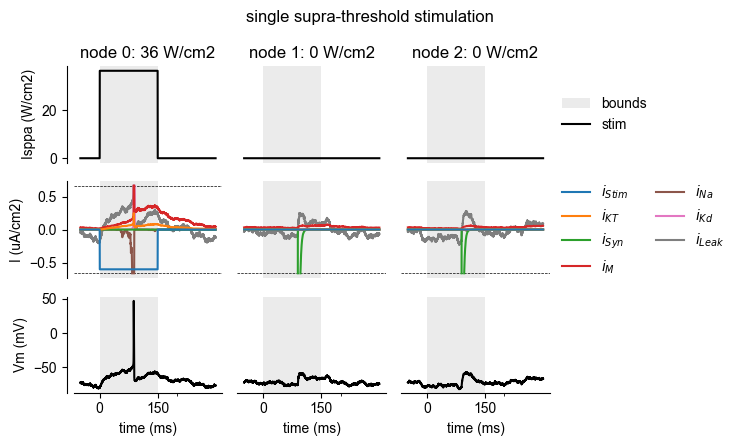

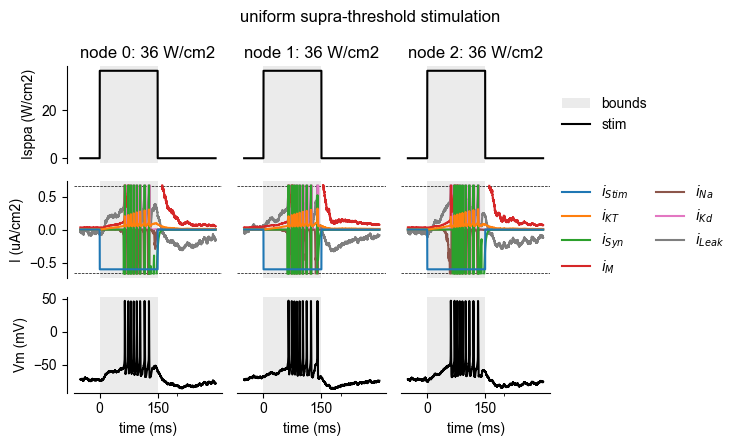

In [6]:
# Set supra-threshold stimulus amplitude
Isppa = Ithr * 1.1

# Add stochastic noise
model.noise_amp = noise_amp  # mA/cm2

# Plot simulation results at threshold 
for kind, xvec in model.get_stimdists().items():
    model.set_stim(Isppa * xvec)
    data = model.simulate()
    title = f'{kind} supra-threshold stimulation'
    figs[title] = model.plot_results(
        data, 
        exclude=[
            'T',
            'conductances', 
        ], 
        clip_currents=True,
    )
    figs[title].suptitle(title)

### Evoked activity across stimulus amplitude/intensity range

 13/02/2024 10:40:44: NeuralNetwork(3): setting 150.00 ms stimulus with amplitude 36.39 W/cm2 on 100.0% of nodes
 13/02/2024 10:40:44: NeuralNetwork(3): running simulation sweep across 30 stimulus intensities


100%|██████████| 30/30 [05:56<00:00, 11.87s/it]


 13/02/2024 10:49:44: NeuralNetwork(3): running simulation sweep across 30 stimulus intensities


100%|██████████| 30/30 [06:03<00:00, 12.10s/it]


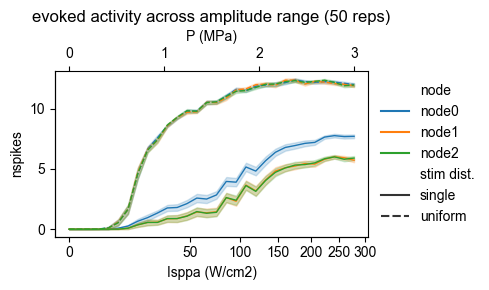

In [7]:
# Set stimulus
model.set_stim(Isppa, start=start, dur=dur)

# Run comparative simulations across Isppa range and extract spike counts
mdata = model.run_comparative_sweep(
    Isppa_range_dense, 
    'nspikes',
    nreps=nreps,
)

# Plot spike count across Isppa range for each noise amplitude
figs[f'nspikes_vs_pressure_{nreps}reps'], ax = plt.subplots(figsize=(5, 3))
ax.set_title(f'evoked activity across amplitude range ({nreps} reps)', fontsize=12)
model.plot_sweep_results(
    mdata, 
    ax=ax, 
    legend=True, 
    marker=None, 
    xscale='sqrt',
    estimator='mean',
)
# Adjust figure layout
figs[f'nspikes_vs_pressure_{nreps}reps'].tight_layout()

## Save figures

In [8]:
# Check that figures directory exists
figsdir = os.path.abspath(figs_dir)
if not os.path.isdir(figsdir):
    raise ValueError(f'Figures directory "{figsdir}" does not exist')

# Save figures in directory
for title, fig in figs.items():
    logger.info(f'Saving "{title}" figure to "{figs_dir}"')
    fpath = os.path.join(figs_dir, f'{title}.pdf')
    if os.path.isfile(fpath):
        logger.warning(f'Figure "{title}" already exists in "{figs_dir}" -> overwriting')
    fig.savefig(fpath)

 13/02/2024 10:59:45: Saving "EI imbalance" figure to "figures/"
 13/02/2024 10:59:46: Saving "single supra-threshold stimulation" figure to "figures/"
 13/02/2024 10:59:46: Saving "uniform supra-threshold stimulation" figure to "figures/"
 13/02/2024 10:59:46: Saving "nspikes_vs_pressure_50reps" figure to "figures/"


## Log completion

In [9]:
logger.info(f'notebook completed in {timedelta(seconds=time.perf_counter() - t0)}')

 13/02/2024 10:59:46: notebook completed in 0:19:07.332940
